# CA5

In [1]:
import matplotlib.pyplot as plt, numpy as np, torch, multiprocessing as mp
from torchvision import datasets, transforms
from sklearn import preprocessing as pp
import scipy.linalg
from sklearn.cluster import KMeans
%matplotlib inline

## Retrieve the data

In [2]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
idat = train_dataset.train_data
odat = train_dataset.train_labels

## Create a support vector machine

In [3]:
class SVM(torch.nn.Sequential):
    
    def __init__(self):
        torch.nn.Sequential.__init__(self, torch.nn.Linear(28*28, 1))
        torch.manual_seed(0)
        self.loss = list()
        
    def __call__(self, x):
        x = x.view(-1, 28*28)
        return torch.nn.Sequential.__call__(self, x)

## Decentralised gradient descent

In [4]:
def train_dgd(net, input_data, output_data, n_agents, learning_rate=1e-4, episodes=2000, gpu=False, p=0.9, R=2):
    
    # loss function
    lf = torch.nn.MSELoss()
    
    # optimiser
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # make the agents' batches
    input_batches = input_data.float().chunk(n_agents)
    output_batches = output_data.float().chunk(n_agents)
    
    # put everything on the GPU if you want
    if gpu:
        net.cuda()
        input_batches = [idat.cuda() for idat in input_batches]
        output_batches = [odat.cuda() for odat in output_batches]
        
    # bernoulli probability and gaussian distribution
    p = torch.distributions.bernoulli.Bernoulli(p)
    R = torch.distributions.normal.Normal(0, R)
    
    # for each training episodes
    for e in range(episodes):
        
        # zero the gradients
        opt.zero_grad()
        
        # average loss
        avgloss = 0
        
        # decentralised gradient descent
        for idat, odat in zip(input_batches, output_batches):
            
            # compute the loss for this guy
            loss = torch.mean(torch.pow(torch.norm(net(idat) + R.sample()*p.sample() -odat, 2, dim=1), 2))
            
            # accumulate gradients
            loss.backward()
            
            # record loss
            avgloss += loss.item()
            
        # record loss
        net.loss.append(avgloss/n_agents)
        
        # optimisation step
        opt.step()
        
        # a nice little message 
        print("Episode {}; Average Loss = {}".format(e, avgloss/n_agents))
        
    return net.cpu()

# a) 
## Train 10 workers with decentralised gradient descent

In [ ]:
net0 = train_dgd(SVM(), idat, odat, 10, 1e-4, 2000, True, 0.2, 2)

## Visually characterise the convergence with $T$

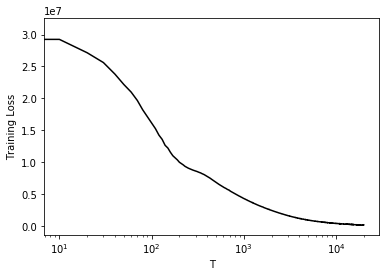

In [6]:
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0, len(net0.loss)*10, len(net0.loss)), net0.loss, "k-")
plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r"T")
ax.set_ylabel(r"Training Loss")
plt.show()

# b) ADMM two star optimisation
## ADMM algorithm

In [7]:
def ADMM(A, B, x=None, l1=0, l2=0.1, lam=1, tol=1e-6, maxiter=500):
    
    # get shapes
    n = A.shape[1]
    k = B.shape[1]

    # pentalty parameters for admm
    lam1 = l1*lam
    lam2 = l2*lam

    # math stuff
    AtA = np.dot(A.T, A)
    AtB = np.dot(A.T, B)
    Afct = scipy.linalg.lu_factor(AtA + np.diag(np.full(n, 1/lam)))

    # proximal operators
    prox_f = lambda v: scipy.linalg.lu_solve(Afct, (AtB + v/lam))
    prox_g = lambda v: (np.maximum(0, v-lam1) - np.maximum(0, -v-lam1)) / (1 + lam2)
    
    # ADMM initialisation
    x = np.random.randn(n, k) if x is None else x
    z = prox_g(x)
    u = x - z
    
    # loss record
    loss = list()

    # optimisation iterations
    for itr in range(maxiter):
        
        # update
        x1 = prox_f(z - u)
        z1 = prox_g(x1 + u)
        u1 = u + x1 - z1

        # primal residuals and dual residuals
        r = np.linalg.norm(x1 - z1)
        s = (1/lam) * np.linalg.norm(z - z1)
        
        # if we converged within tol
        if r < np.sqrt(x.size)*tol and s < np.sqrt(x.size)*tol:
            return z, loss

        # update variables for next iteration
        x, z, u = x1, z1, u1
        loss.append(np.linalg.norm(A.dot(x) - B))

    return x, loss

## Two star trainer

In [8]:
def train2star(A, B, epo=10):
    
    # split the data into chunks
    As = np.vsplit(A, 8)
    Bs = np.vsplit(B, 8)
    
    # initialise guess
    x = None
    
    # main loss
    loss = list()
    
    # main trianing loop
    for e in range(epo):
        
        # inner loss
        l = 0
        
        # first star
        for i in [0, 1, 2, 3]:
            
            # get solution and loss
            x, loss = ADMM(As[i], Bs[i], x=x, maxiter=10)
            
            # record loss
            l += loss[-1]
            
        
        # second star
        for i in [4, 5, 6, 7]:
            
            # get solution and loss
            x, loss = ADMM(As[i], Bs[i], x=x, maxiter=10)
            
            # record loss
            l += loss[-1]
            
        # average loss
        loss.append(l/8)
        print(l/8)
        
    return x, loss

## Format the data

In [9]:
# normalise each image, flatten it, and make each a row in the database
A = np.vstack([pp.normalize(dat.numpy()).flatten()  for dat in idat])

# output values
b = odat.view(-1, 1).numpy()

## Perform the optimisaton

In [10]:
x, loss = ADMM(A, b)

## Visualise

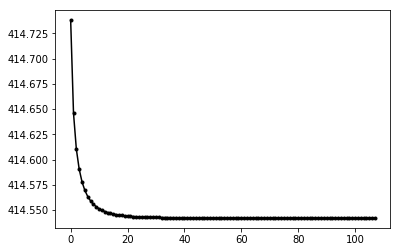

In [11]:
plt.plot(loss, "k.-")
plt.show()

## Characterise convergence with $T$

blah blah

In [ ]:
x, loss = ADMM(A, b, maxiter=2)
for r in range(200):
    x, l = ADMM(A, b, x=x, maxiter=2)
    loss.append(l[-1])
loss

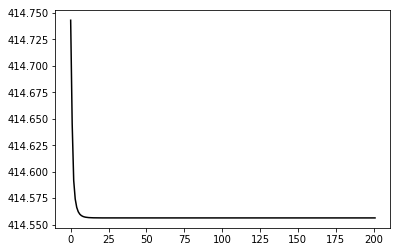

In [22]:
plt.plot(loss, "k-")
plt.show()

# c)
## Propose an approach to reduce $T$

We propose that increasing the number of stars within the configuration decreases the number of exchanges to the masters among worker nodes. We see that the convergence rate between among different $N$ star configurations is the same. So by increasing the number of stars in the configuration, we keep the convergence rate constant, but decrease the number of exachanges to master nodes.

## Pros and cons
By increasing the number of masters within the configurations, the structure becomes more decentralised, meaning we relly less on a single master. But at the same time, as we increase the number of masters, the process of parallelising the algorithm becomes more ardous.

# d)
## 4 bits

In [14]:
Q4 = KMeans(n_clusters=4, random_state=0).fit(A)
Q4.labels_

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [15]:
Q4.labels_.shape

(60000,)

## 32 bits

In [16]:
Q32 = KMeans(n_clusters=32, random_state=0).fit(A)
Q32.labels_

array([20, 18, 22, ..., 20, 16, 21], dtype=int32)

# e)
## New SVM format

In [17]:
class SVMK(torch.nn.Sequential):
    
    def __init__(self):
        torch.nn.Sequential.__init__(self, torch.nn.Linear(1, 1))
        torch.manual_seed(0)
        self.loss = list()
        
    def __call__(self, x):
        return torch.nn.Sequential.__call__(self, x)

In [18]:
datak = torch.Tensor(Q32.labels_.reshape(-1, 1))
datak

tensor([[20.],
        [18.],
        [22.],
        ...,
        [20.],
        [16.],
        [21.]])

## (a) repeated

In [ ]:
netk = train_dgd(SVMK(), datak, odat, 10, 1e-3, 4000, True, p=0)

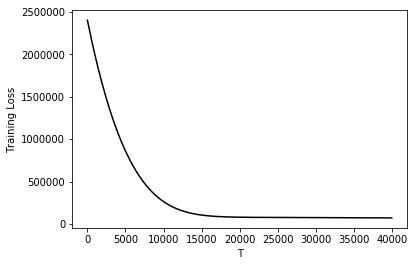

In [20]:
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0, len(netk.loss)*10, len(netk.loss)), netk.loss, "k-")
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r"T")
ax.set_ylabel(r"Training Loss")
plt.show()

## (b) repeated

In [119]:
x, loss = ADMM(datak.numpy(), b, l1=0, l2=5, lam=0.1, tol=1e-6, maxiter=500)

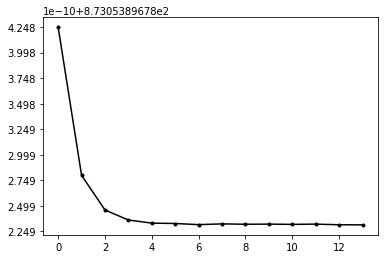

In [120]:
plt.plot(loss, "k.-")
plt.show()

# f)

Similarily to what we did in part (d), we can perform quantization on the gradients that are shared between the workers in both the SVRG and SAG algorithms.